This notebook was developed over the nextGEMS hackathon (Wageningen 14th-18th October). It is designed to work on Levante and compares the effects of different re-gridding methods on  small regions / variables with steep graidents. It runs on the IFS-FESOM historical run (approx 10 km) and uses two different intake methods, both developed for the Destination Earth initiative: the AQUA reader and the Generic State Vector (GSV) interface. 

The case study uses `mtpr' (precipitation rate) over the Canary islands. This variable was chosen as it's avaliabe both in the native IFS grid and as healpix zoom level 9 on the FDB. The method used to regrid between native to heaplix (done before storing on the FDB) is CDO - conservative.

Here we compare each re-gridding method to the native grid resolution. The code used for computing the error is based off: 
https://easy.gems.dkrz.de/Processing/healpix/plot-difference.html

This code on the website works for comparing native grid to healpix. We have modified slightly to include also a comparison with lat-lon.

Note we don't test bilinear and bicubic as they don't support repmapping from unstructured grids

I run this notebook using the AQUA environment :
https://github.com/DestinE-Climate-DT/AQUA/tree/main (then pip installed easygems)

Summary of all the errors from the different methods printed at the bottom


In [92]:
import numpy as np 
import os 
import xarray as xr
#import regionmask 
#import geopandas as gp
import cmocean 
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

import easygems.healpix as egh
from scipy.spatial import KDTree

import matplotlib.tri as tri

#import easygems.healpix as egh
import healpy as hp

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#import easygems.healpix as egh
import cartopy.feature as cf
import healpy as hp

# importing AQUA 
import aqua
from aqua import Reader

# importing GSV 
from gsv import GSVRetriever
from gsv.requests.parser import parse_request
from gsv.requests.utils import convert_to_step_format

# intake for nextGEMS
import intake
!hostname



l40048.lvt.dkrz.de


In [93]:
var = 'mtpr'

#coordinates of Canary islands whole domain 
latitude = [27.2, 29.5]
longitude = [-19, -12.5]

In [94]:
def get_nn_lon_lat_index(nside, lons, lats):
    "converts healpix grid to lat lon coords"
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
        coords=[("lat", lats), ("lon", lons)],
    )

def get_nn_data(var, nx=1000, ny=1000, ax=None):
    """
    var: variable (array-like)
    nx: image resolution in x-direction for the comparsion grid
    ny: image resolution in y-direction for the comparison grid
    ax: axis to plot on
    returns: values on the points in the plot grid.
    """

    lonlat = get_lonlat_for_plot_grid(nx, ny, ax)
    try:
        return get_healpix_nn_data(var, lonlat)
    except:
        return get_lonlat_nn_data(var, lonlat)


def get_healpix_nn_data(var, lonlat):
    
    """
    var: variable on healpix coordinates (array-like)
    lonlat: coordinates at which to get the data
    returns: values on the points in the plot grid.
    """
    valid = np.all(np.isfinite(lonlat), axis=-1)
    points = lonlat[valid].T  # .T reverts index order
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=True, lonlat=True
    )
    res = np.full(lonlat.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return res


def get_lonlat_nn_data(var, lonlat):
    """
    var: variable with lon and lat attributes (2d slice)
    lonlat: coordinates at which to get the data
    returns: values on the points in the plot grid.
    """

    lon=var.lon
    lat=var.lat

    # indentifing if it's a lat lon grid
    if len(np.shape(var)) > 1:
        vlon, vlat = np.meshgrid(lon, lat)
        var_xyz = lonlat_to_xyz(lon=vlon.flatten(), lat=vlat.flatten())
    else:
        var_xyz = lonlat_to_xyz(lon=lon, lat=lat)
        
    tree = KDTree(var_xyz)

    valid = np.all(np.isfinite(lonlat), axis=-1)
    ll_valid = lonlat[valid].T
    plot_xyz = lonlat_to_xyz(lon=ll_valid[0], lat=ll_valid[1])

    distances, inds = tree.query(plot_xyz)
    res = np.full(lonlat.shape[:-1], np.nan, dtype=var.dtype)
    
    if len(np.shape(var)) > 1:
        res[valid] = var.values.flatten()[inds]
    else:
        res[valid] = var[inds]
    return res


def get_lonlat_for_plot_grid(nx, ny, ax=None):
    """
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    returns: coordinates of the points in the plot grid.
    """

    if ax is None:
        ax = plt.gca()
        
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    lonlat = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    return lonlat


def lonlat_to_xyz(lon, lat):
    """
    lon: longitude in degree E
    lat: latitude in degree N
    returns numpy array (3, len (lon)) with coordinates on unit sphere.
    """

    return np.array(
        (
            np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat)),
            np.sin(np.deg2rad(lon)) * np.cos(np.deg2rad(lat)),
            np.sin(np.deg2rad(lat)),
        )
    ).T
    

def plot_map_diff(var, ref, colorbar_label="", title="", **kwargs):
    """
    var: data set
    ref: reference data
    colorbar_label: label for the colorbar
    title: title string
    **kwargs: get passed to imshow
    returns figure, axis objects
    """
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_extent([longitude[0], longitude[1], latitude[0], latitude[1]], crs=projection)

    varmap = get_nn_data(var, ax=ax)
    refmap = get_nn_data(ref, ax=ax)
           
    imsh = ax.imshow(
        varmap - refmap, extent=ax.get_xlim() + ax.get_ylim(), origin="lower", **kwargs
    )
    
    error = np.sqrt(np.sum((refmap - varmap)**2)/np.size(varmap))
    
    error = np.round(error,10)
    print('absolute RMS error:', error)
    
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    fig.colorbar(imsh, label=colorbar_label)
    plt.title(f"{title} {error}")
    return (fig, ax, error)

In [122]:
def ticks_round(ticks: list, round_to: int = None):
    """
    Round a tick to the nearest round_to value.

    tick (list):          Tick value.
    round_to (int, opt):  Round to value.

    Returns:
        tick (list):  Rounded tick value.
    """
    if round_to is None:
        # define round_to
        tick_span = ticks[1] - ticks[0]
        if tick_span <= 1:
            round_to = 2
        elif tick_span > 1 and tick_span <= 10:
            round_to = 1
        else:
            round_to = 0

    return np.round(ticks, round_to)

In [95]:

def plot_islands(to_plot, grid_type, max_value, title):

    projection = ccrs.PlateCarree()

    fsize = 14
    #Add tick marks with values for latitude and longitude axes
    nxticks = 5
    nyticks = 7
    
    # coordinates of La Palma southern tip 
    # this part was to see where the same 'real' co-ordinate was plotted on different re-grids
    # lat_palma = 28.455732
    # lon_palma = -17.838980

    # lat_cruz = 28.100639
    # lon_cruz = -14.499162

    # if grid_type == 'lat_lon':
    #     closest_point = to_plot.sel(lat=lat_palma, lon=lon_palma, method='nearest')
    #     loni = np.where(to_plot.lon == closest_point.lon.values)[0][0]
    #     lati = np.where(to_plot.lat == closest_point.lat.values)[0][0]
    #     print('closest point palma lat:', closest_point.lat.values, 'lon:', closest_point.lon.values,
    #         'real: ', lat_palma, lon_palma)

    #     closest_point = to_plot.sel(lat=lat_cruz, lon=lon_cruz, method='nearest')
    #     loni2 = np.where(to_plot.lon == closest_point.lon.values)[0][0]
    #     lati2 = np.where(to_plot.lat == closest_point.lat.values)[0][0]
    #     print('closest point cruz lat:', closest_point.lat.values, 'lon:', closest_point.lon.values,
    #         'real: ', lat_cruz, lon_cruz)

    cmap = cmocean.cm.thermal
    cmap = cmap(np.linspace(0, 1, 20))
    cmap = ListedColormap(cmap)

    fig, ax = plt.subplots(1, 1, constrained_layout=False, figsize=(10, 10), 
                            subplot_kw={'projection': projection}) 


    if grid_type == "lat_lon":
        lons, lats = np.meshgrid(to_plot.lon.values, to_plot.lat.values)
        
        pcm = ax.pcolormesh(lons, lats, to_plot, transform= projection, 
            cmap=cmap, vmax = max_value) 
        
        # ax.plot(to_plot.lon[loni], to_plot.lat[lati], marker='x', color='red', markersize=6, transform=projection)
        # ax.plot(to_plot.lon[loni2], to_plot.lat[lati2], marker='x', color='red', markersize=6, transform=projection)
    
    elif grid_type == "healpix":
        
        ax.set_global()
        ax.set_extent([longitude[0], longitude[1], latitude[0], latitude[1]], crs=projection)
        pcm = egh.healpix_show(to_plot, ax=ax, vmax = max_value, cmap = cmap)

    elif grid_type == "native":
        triang = tri.Triangulation(to_plot.lon, to_plot.lat)
        pcm = plt.tricontourf(triang, to_plot.data, alpha=1, levels=np.linspace(0, max_value, 20),
            cmap=cmap, transform= projection) 

    ax.coastlines(resolution='10m', color='black', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        
    plt.title(f'{title}')

    # Latitude labels
    if grid_type == "healpix":
        lat_min = latitude[0]
        lat_max = latitude[1]
    else:
        lat_min = to_plot['lat'].values.min()
        lat_max = to_plot['lat'].values.max()
    step = (lat_max - lat_min) / (nyticks - 1)
    yticks = np.arange(lat_min, lat_max, step)
    yticks = ticks_round(ticks=yticks, round_to=None)
    ax.set_yticks(yticks, crs=projection)
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    # Latitude labels
    if grid_type == "healpix":
        lon_min = longitude[0]
        lon_max = longitude[1]
    else:
        lon_min = to_plot['lon'].values.min()
        lon_max = to_plot['lon'].values.max()
    step = (lon_max - lon_min) / (nxticks - 1)
    xticks = np.arange(lon_min, lon_max + 1, step)
    xticks = ticks_round(ticks=xticks, round_to=None)
    ax.set_xticks(xticks, crs=projection)
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    ax.tick_params(axis='y', labelsize=fsize) 
    ax.tick_params(axis='x', labelsize=fsize) 

    cbar_ax = fig.add_axes([0.36, 0.3, 0.28, 0.01]) 
    cbar = fig.colorbar(pcm, cax = cbar_ax, orientation='horizontal', shrink=0.4)
    
    cbar.set_ticks([0, max_value/3, 2*max_value/3, max_value])

    cbar.update_ticks()  # Updates the colorbar with the new ticks

    cbar.ax.tick_params(labelsize=fsize)
    cbar.set_label(f"{var}", fontsize = fsize)

    plt.show()


## native grid

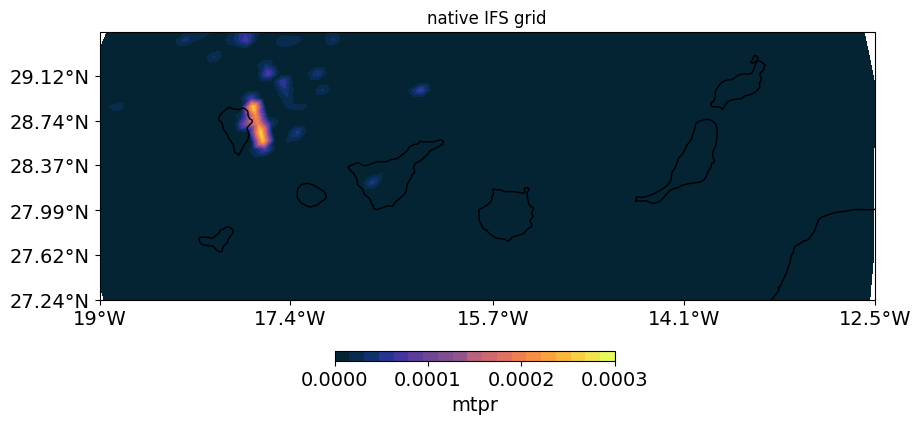

In [96]:
reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-native-atm2d-fdb1", streaming=True, 
                aggregation = 'D', chunks = {'time' : 'D'}, startdate = '19900101')

data = reader.retrieve(var = var)

data = data[var]

# converting co-ords into degrees from radian
data['lon'] = data['lon']*180/(np.pi)
data['lat'] = data['lat']*180/(np.pi)

# selecting the area over Canary islands
indexer = ((data.lat>=latitude[0]) & (data.lat<=latitude[1]) & (data.lon>=longitude[0]) & (data.lon<=longitude[1])).compute()
data_nat = data.where(indexer, drop=True)

# using a fixed value for all the plots based on native data 
cbar_max = np.round(np.max(data_nat.sum(axis = 0).values), 4)

plot_islands(data_nat.sum(axis = 0), "native", cbar_max, "native IFS grid")


## regrid native to lat lon

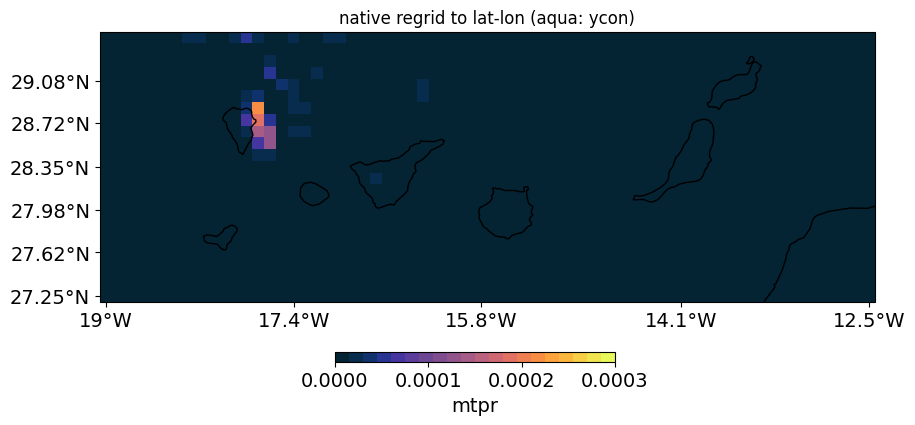

In [97]:
# here including the regridding funciton to 0.1 degree - using default conservative method (default)
reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-native-atm2d-fdb1", streaming=True, 
                regrid = 'r010', aggregation = 'D', chunks = {'time' : 'D'}, startdate = '19900101')

data = reader.retrieve()

data = data[var]

# regridding from native to lat-lon 
data = reader.regrid(data)

# moving the longitude co-ordinates
data['lon_adjusted'] = xr.where(data.lon > 180, data.lon - 360, data.lon)
data['lon'] = data['lon_adjusted']
data = data.reset_coords(names='lon_adjusted', drop=True)

indexer = ((data.lat>=latitude[0]) & (data.lat<=latitude[1]) & (data.lon>=longitude[0]) & (data.lon<=longitude[1])).compute()
data_nat_ll = data.where(indexer, drop=True)

plot_islands(data_nat_ll.sum(axis = 0), "lat_lon", cbar_max, "native regrid to lat-lon (aqua: ycon)")

# looking at comparing everything against native grid

absolute RMS error: 7.7716e-06


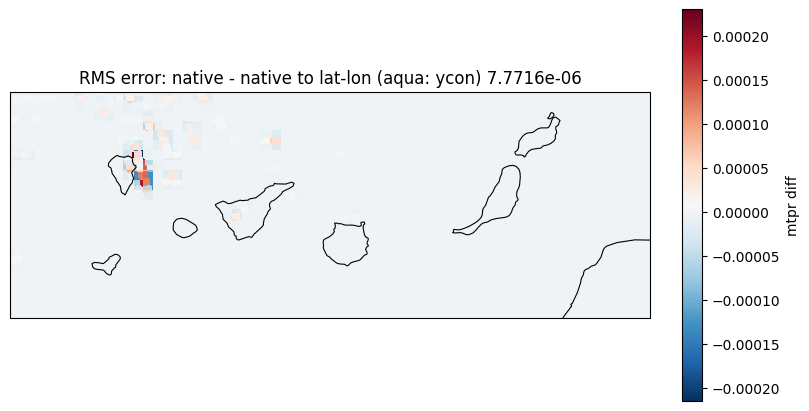

In [98]:
# plot1 = xr.zeros_like(data_nat[0,:])
# plot2 = xr.zeros_like(data_nat_ll[0,:,:])

# to check how the comparison works, plot the native or lat lon data against 
# plot1 or plot2 respectively and the orignal map should be recovered 

fig, ax, nat_ll_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_nat_ll.sum(axis = 0),
    cmap='RdBu_r',
    interpolation="none",
    colorbar_label="mtpr diff",
    title="RMS error: native - native to lat-lon (aqua: ycon)",
)

## native to lat-lon with nn

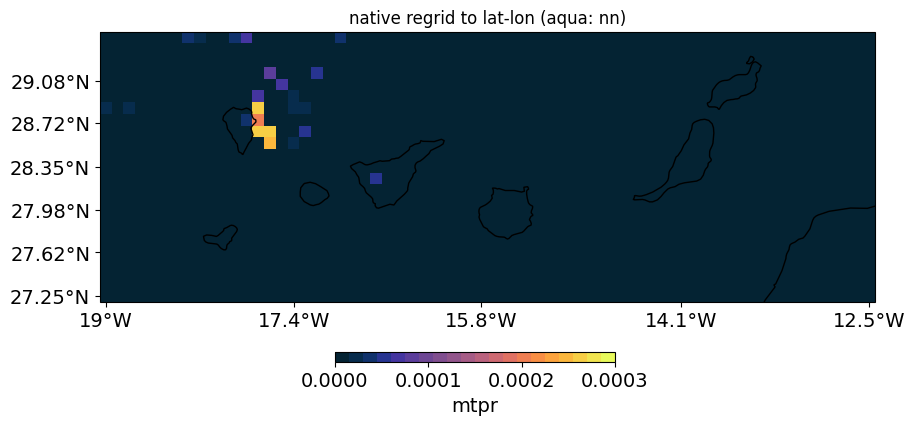

In [99]:
method = 'nn'

reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-native-atm2d-fdb1", streaming=True, 
                regrid = 'r010', aggregation = 'D', chunks = {'time' : 'D'}, startdate = '19900101', regrid_method = method)

data = reader.retrieve()

data = data[var]

data = reader.regrid(data)

data['lon_adjusted'] = xr.where(data.lon > 180, data.lon - 360, data.lon)
data['lon'] = data['lon_adjusted']
data = data.reset_coords(names='lon_adjusted', drop=True)

indexer = ((data.lat>=latitude[0]) & (data.lat<=latitude[1]) & (data.lon>=longitude[0]) & (data.lon<=longitude[1])).compute()
data_nat_ll_nn = data.where(indexer, drop=True)

# print(data_nat_ll.lon.values)
# print(data_nat_ll.lat.values)

plot_islands(data_nat_ll_nn.sum(axis = 0), "lat_lon", cbar_max, f"native regrid to lat-lon (aqua: {method})")

absolute RMS error: 1.02201e-05


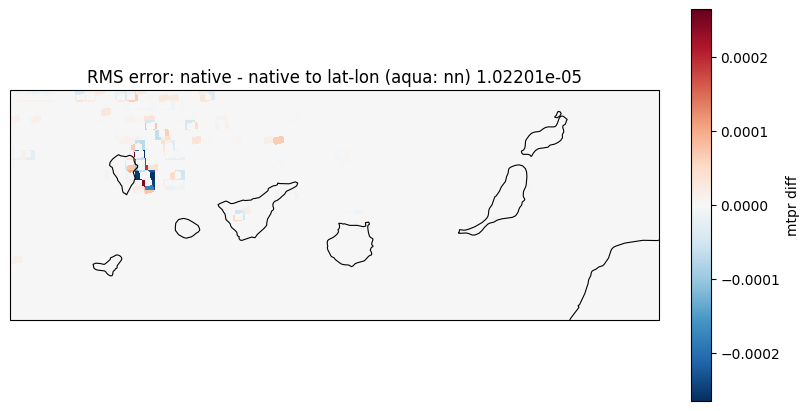

In [100]:
fig, ax, nat_ll_nn_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_nat_ll_nn.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title=f"RMS error: native - native to lat-lon (aqua: {method})",
)

## nat to lat lon with distance weighted

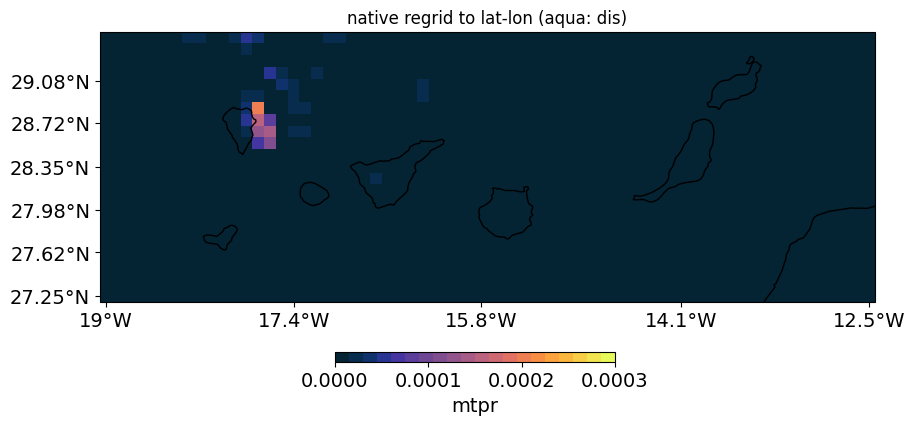

In [101]:
method = 'dis'

reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-native-atm2d-fdb1", streaming=True, 
                regrid = 'r010', aggregation = 'D', chunks = {'time' : 'D'}, startdate = '19900101', regrid_method = method)

data = reader.retrieve()

data = data[var]

data = reader.regrid(data)

data['lon_adjusted'] = xr.where(data.lon > 180, data.lon - 360, data.lon)
data['lon'] = data['lon_adjusted']
data = data.reset_coords(names='lon_adjusted', drop=True)

indexer = ((data.lat>=latitude[0]) & (data.lat<=latitude[1]) & (data.lon>=longitude[0]) & (data.lon<=longitude[1])).compute()
data_nat_ll_dis = data.where(indexer, drop=True)


plot_islands(data_nat_ll_dis.sum(axis = 0), "lat_lon", cbar_max, f"native regrid to lat-lon (aqua: {method})")

absolute RMS error: 7.874e-06


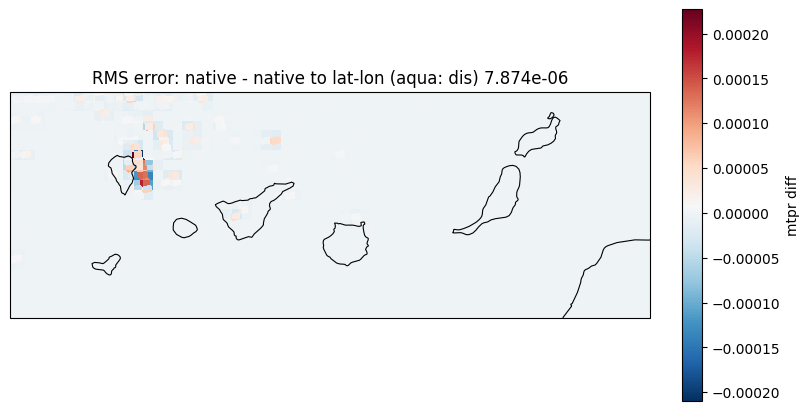

In [102]:
fig, ax, nat_ll_dis_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_nat_ll_dis.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title=f"RMS error: native - native to lat-lon (aqua: {method})",
)

## nat to lat lon with largest area fraction

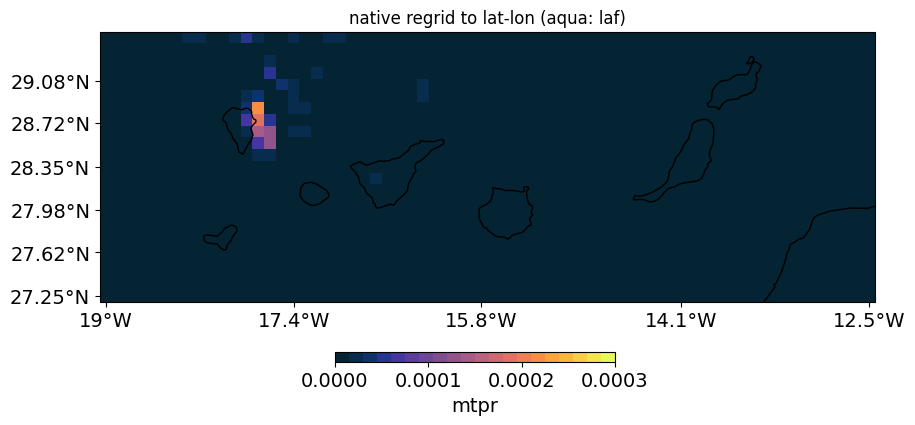

In [103]:
method = 'laf'

reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-native-atm2d-fdb1", streaming=True, 
                regrid = 'r010', aggregation = 'D', chunks = {'time' : 'D'}, startdate = '19900101', regrid_method = method)

data = reader.retrieve()

data = data[var]

data = reader.regrid(data)

data['lon_adjusted'] = xr.where(data.lon > 180, data.lon - 360, data.lon)
data['lon'] = data['lon_adjusted']
data = data.reset_coords(names='lon_adjusted', drop=True)

indexer = ((data.lat>=latitude[0]) & (data.lat<=latitude[1]) & (data.lon>=longitude[0]) & (data.lon<=longitude[1])).compute()
data_nat_ll_laf = data.where(indexer, drop=True)

plot_islands(data_nat_ll_laf.sum(axis = 0), "lat_lon", cbar_max, f"native regrid to lat-lon (aqua: {method})")

absolute RMS error: 7.7716e-06


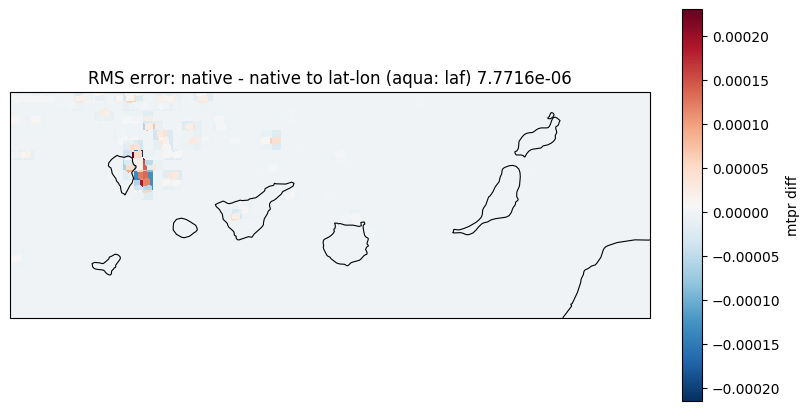

In [104]:
fig, ax, nat_ll_laf_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_nat_ll_laf.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title=f"RMS error: native - native to lat-lon (aqua: {method})",
)

# from healpix and re-gridding to lat lon with AQUA

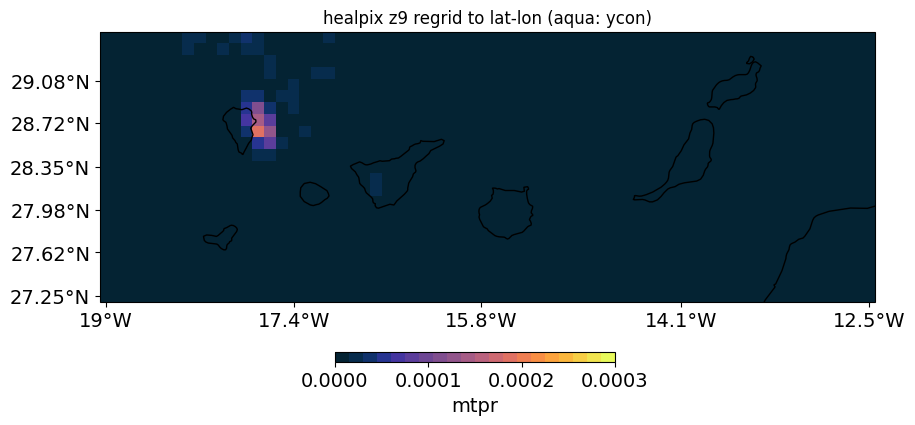

In [105]:
# don't use the healpix 512 (chunking not working properly)

reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-hpz9-atm2d-fdb1",  streaming=True, 
                regrid = 'r010', aggregation = 'D', chunks='D', startdate = '19900101')

data = reader.retrieve(var = var)

data = data[var]

data = reader.regrid(data)

data['lon_adjusted'] = xr.where(data.lon > 180, data.lon - 360, data.lon)
data['lon'] = data['lon_adjusted']
data = data.reset_coords(names='lon_adjusted', drop=True)

indexer = ((data.lat>=latitude[0]) & (data.lat<=latitude[1]) & (data.lon>=longitude[0]) & (data.lon<=longitude[1])).compute()
data_hp_ll = data.where(indexer, drop=True)

plot_islands(data_hp_ll.sum(axis = 0), "lat_lon", cbar_max, "healpix z9 regrid to lat-lon (aqua: ycon)")

absolute RMS error: 8.7869e-06


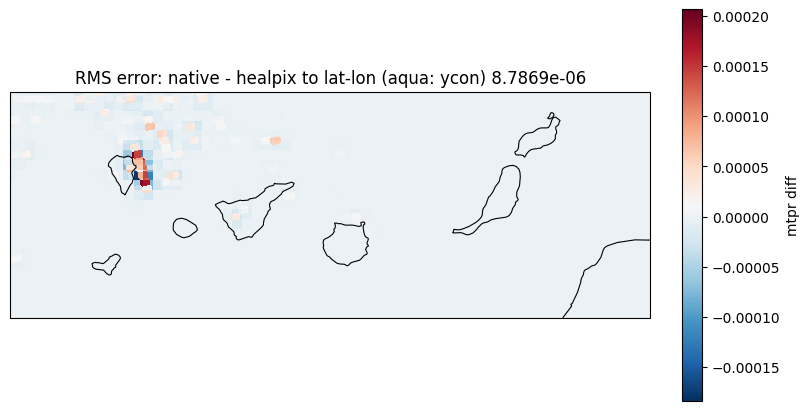

In [106]:

fig, ax, hp_ll_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_hp_ll.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title="RMS error: native - healpix to lat-lon (aqua: ycon)",
)

## healpix regrid to lat lon with nn

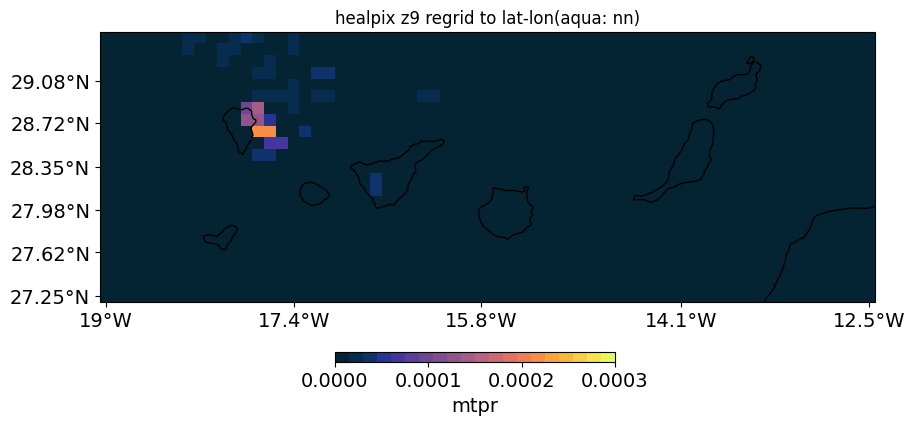

In [107]:
# don't use the healpix 512 (chunking not working properly)

method = 'nn'
reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-hpz9-atm2d-fdb1",  streaming=True, 
                regrid = 'r010', aggregation = 'D', chunks='D', startdate = '19900101', regrid_method = method)

data = reader.retrieve(var = var)

data = data[var]

data = reader.regrid(data)

data['lon_adjusted'] = xr.where(data.lon > 180, data.lon - 360, data.lon)
data['lon'] = data['lon_adjusted']
data = data.reset_coords(names='lon_adjusted', drop=True)

indexer = ((data.lat>=latitude[0]) & (data.lat<=latitude[1]) & (data.lon>=longitude[0]) & (data.lon<=longitude[1])).compute()
data_hp_ll_nn = data.where(indexer, drop=True)

plot_islands(data_hp_ll_nn.sum(axis = 0), "lat_lon", cbar_max, f"healpix z9 regrid to lat-lon(aqua: {method})")

absolute RMS error: 9.703e-06


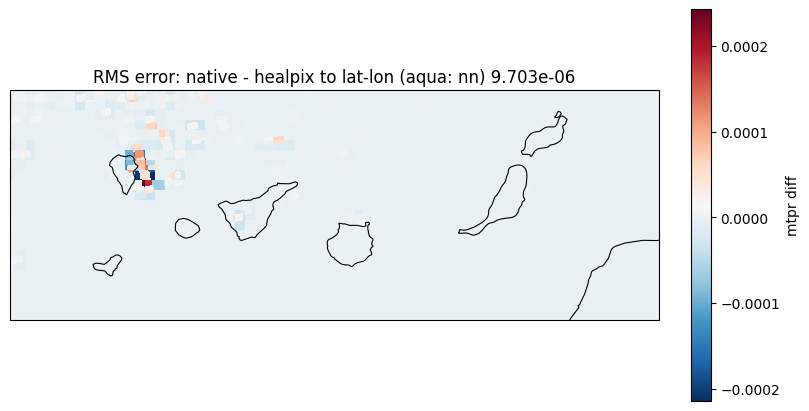

In [108]:

fig, ax, hp_ll_nn_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_hp_ll_nn.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title=f"RMS error: native - healpix to lat-lon (aqua: {method})",
)

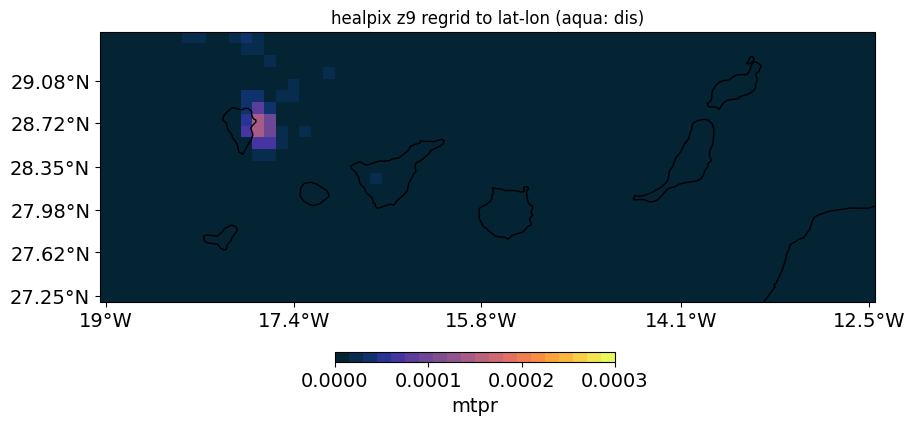

In [109]:
# don't use the healpix 512 (chunking not working properly)

method = 'dis'
reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-hpz9-atm2d-fdb1",  streaming=True, 
                regrid = 'r010', aggregation = 'D', chunks='D', startdate = '19900101', regrid_method = method)

data = reader.retrieve(var = var)

data = data[var]

data = reader.regrid(data)

data['lon_adjusted'] = xr.where(data.lon > 180, data.lon - 360, data.lon)
data['lon'] = data['lon_adjusted']
data = data.reset_coords(names='lon_adjusted', drop=True)

indexer = ((data.lat>=latitude[0]) & (data.lat<=latitude[1]) & (data.lon>=longitude[0]) & (data.lon<=longitude[1])).compute()
data_hp_ll_dis = data.where(indexer, drop=True)

plot_islands(data_hp_ll_dis.sum(axis = 0), "lat_lon", cbar_max, f"healpix z9 regrid to lat-lon (aqua: {method})")

absolute RMS error: 9.1199e-06


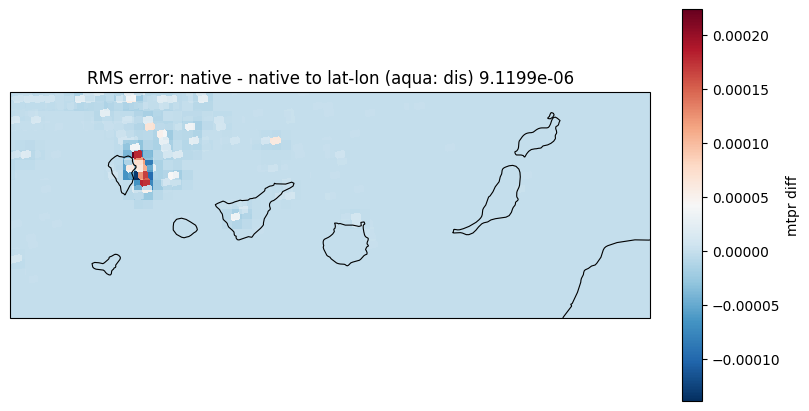

In [110]:
fig, ax, hp_ll_dis_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_hp_ll_dis.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title="RMS error: native - native to lat-lon (aqua: dis)",
)

2024-10-18 15:34:10 :: Reader :: WARNING  -> Weights file not found: /work/bb1153/b382075/aqua/weights/weights_hpz9-nested_laf_r010_l2d.nc
2024-10-18 15:34:10 :: Reader :: WARNING  -> Attempting to generate it ...
2024-10-18 15:35:52 :: Reader :: WARNING  -> Success!


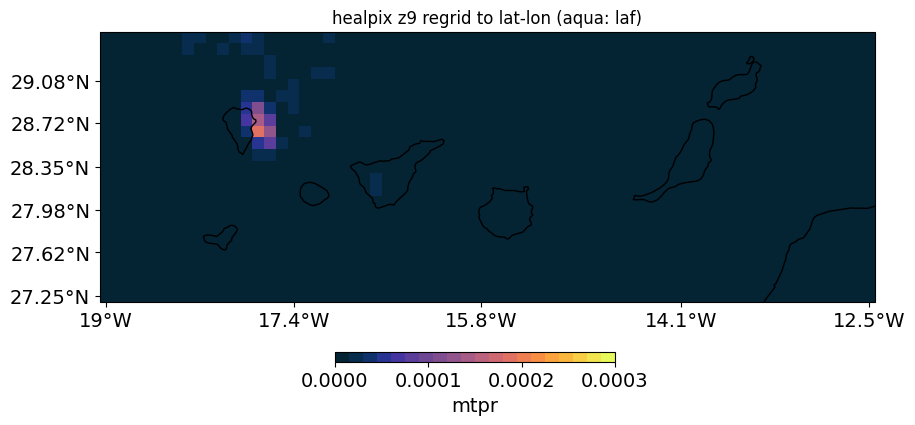

In [111]:
# don't use the healpix 512 (chunking not working properly)

method = 'laf'
reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-hpz9-atm2d-fdb1",  streaming=True, 
                regrid = 'r010', aggregation = 'D', chunks='D', startdate = '19900101', regrid_method = method)

data = reader.retrieve(var = var)

data = data[var]

data = reader.regrid(data)

data['lon_adjusted'] = xr.where(data.lon > 180, data.lon - 360, data.lon)
data['lon'] = data['lon_adjusted']
data = data.reset_coords(names='lon_adjusted', drop=True)

indexer = ((data.lat>=latitude[0]) & (data.lat<=latitude[1]) & (data.lon>=longitude[0]) & (data.lon<=longitude[1])).compute()
data_hp_ll_dis = data.where(indexer, drop=True)

plot_islands(data_hp_ll_dis.sum(axis = 0), "lat_lon", cbar_max, f"healpix z9 regrid to lat-lon (aqua: {method})")

absolute RMS error: 8.7869e-06


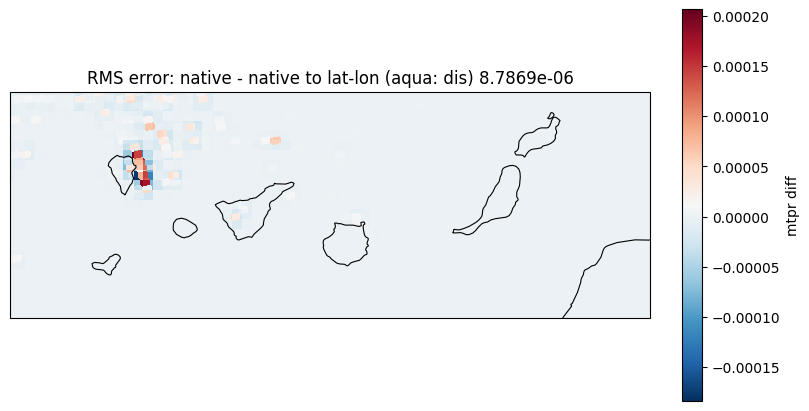

In [112]:
fig, ax, hp_ll_laf_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_hp_ll_dis.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title="RMS error: native - native to lat-lon (aqua: dis)",
)

## heaplix no regrid

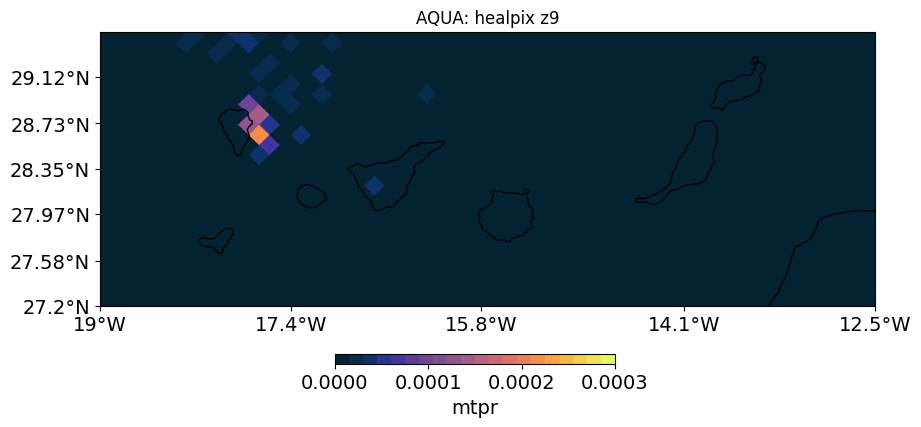

In [113]:
# don't use the healpix 512 (chunking not working properly)

reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-hpz9-atm2d-fdb1",  streaming=True, 
                regrid = 'r010', aggregation = 'D', chunks='D', startdate = '19900101')

data = reader.retrieve()

data = data[var]

data['lon_adjusted'] = xr.where(data.lon > 180, data.lon - 360, data.lon)
data['lon'] = data['lon_adjusted']
data = data.reset_coords(names='lon_adjusted', drop=True)

data_hp = data

plot_islands(data_hp.sum(axis = 0), "healpix", cbar_max, "AQUA: healpix z9")

absolute RMS error: 8.5041e-06


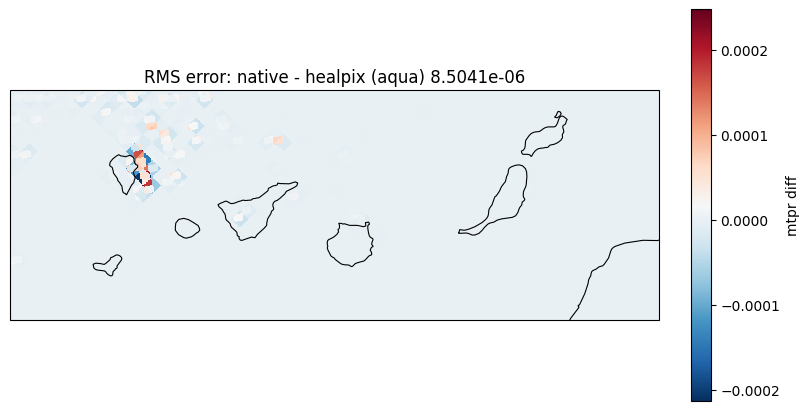

In [114]:

fig, ax, hp_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_hp.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title="RMS error: native - healpix (aqua)",
)

## plotting directly from healpix with own nn - not using CDO but following method found here: 
https://easy.gems.dkrz.de/Processing/healpix/lonlat_remap.html

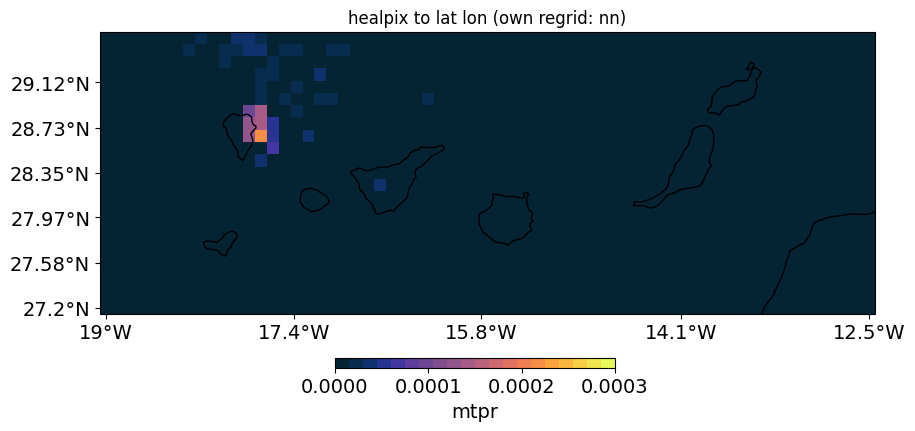

In [115]:

reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-hpz9-atm2d-fdb1",  streaming=True, 
                aggregation = 'D', chunks='D', startdate = '19900101')

data = reader.retrieve(var = var)

data = data[var]

zoom = 9
idx = get_nn_lon_lat_index(
    2**zoom, np.linspace(longitude[0], longitude[1], int((longitude[1] - longitude[0])/0.1)), 
    np.linspace(latitude[0], latitude[1], int((latitude[1] - latitude[0])/0.1))
)

data = data.drop_vars('lon', errors = "ignore")
data = data.drop_vars('lat', errors = "ignore")

# this does your re-gridding
data_hp_ll_nn_own = data.isel(ncells=idx)

plot_islands(data_hp_ll_nn_own.sum(axis = 0), "lat_lon", cbar_max, "healpix to lat lon (own regrid: nn)")

absolute RMS error: 9.652e-06


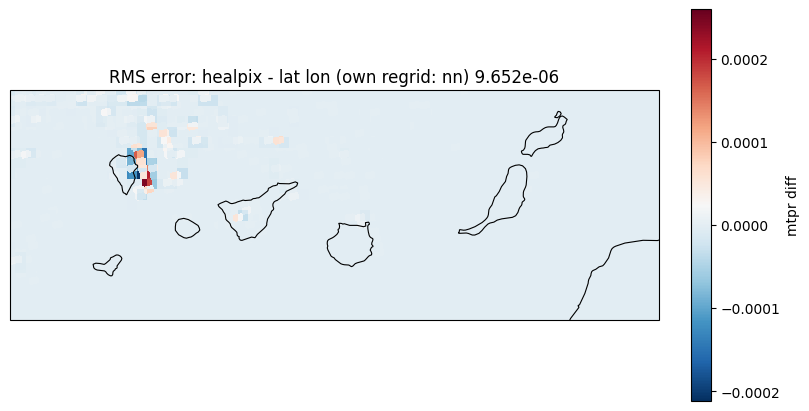

In [116]:

fig, ax, hp_ll_own_nn_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_hp_ll_nn_own.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title="RMS error: healpix - lat lon (own regrid: nn)",
)

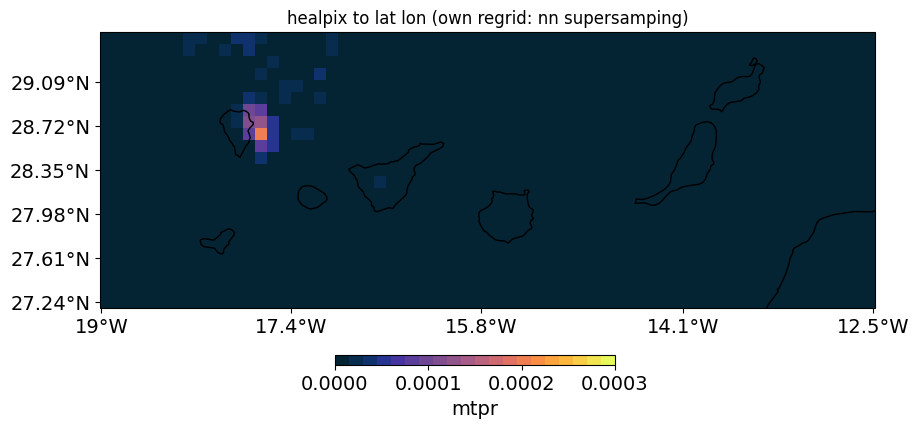

In [117]:
# using the same own regridding but adding supersampling 

reader = Reader(model="IFS-FESOM", exp="historical-1990", source="hourly-hpz9-atm2d-fdb1",  streaming=True, 
                aggregation = 'D', chunks='D', startdate = '19900101')

data = reader.retrieve(var = var)

data = data[var]

zoom = 9
supersampling = {"lon": 4, "lat": 4}
idx = get_nn_lon_lat_index(
    2**zoom, np.linspace(longitude[0], longitude[1], supersampling["lon"] *int((longitude[1] - longitude[0])/0.1)), 
    np.linspace(latitude[0], latitude[1], supersampling["lat"] *int((latitude[1] - latitude[0])/0.1))
)

data = data.drop_vars('lon', errors = "ignore")
data = data.drop_vars('lat', errors = "ignore")

# this does your re-gridding
data_hp_ll_own_nn_ss = data.isel(ncells=idx).coarsen(supersampling).mean()
plot_islands(data_hp_ll_own_nn_ss.sum(axis = 0), "lat_lon", cbar_max, "healpix to lat lon (own regrid: nn supersamping)")

absolute RMS error: 8.5259e-06


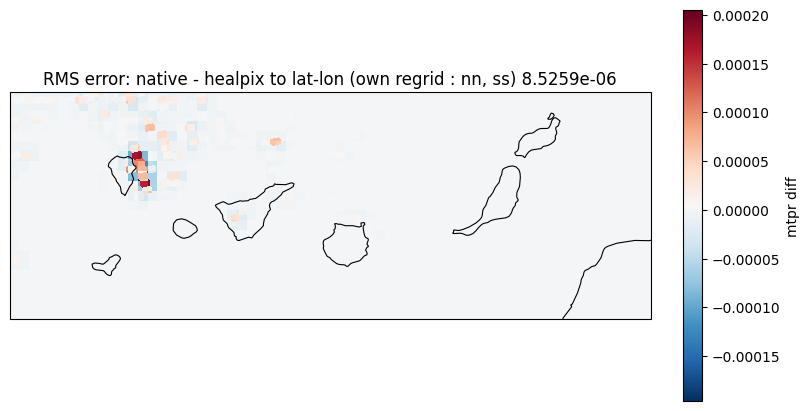

In [118]:
fig, ax, hp_ll_own_nn_ss_error = plot_map_diff(
    data_nat.sum(axis = 0),
    data_hp_ll_own_nn_ss.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title="RMS error: native - healpix to lat-lon (own regrid : nn, ss)",
)

## Using GSV

In [119]:
os.environ['FDB_HOME']

'/work/bm1235/b382776/cycle4_hist/fdb/healpix'

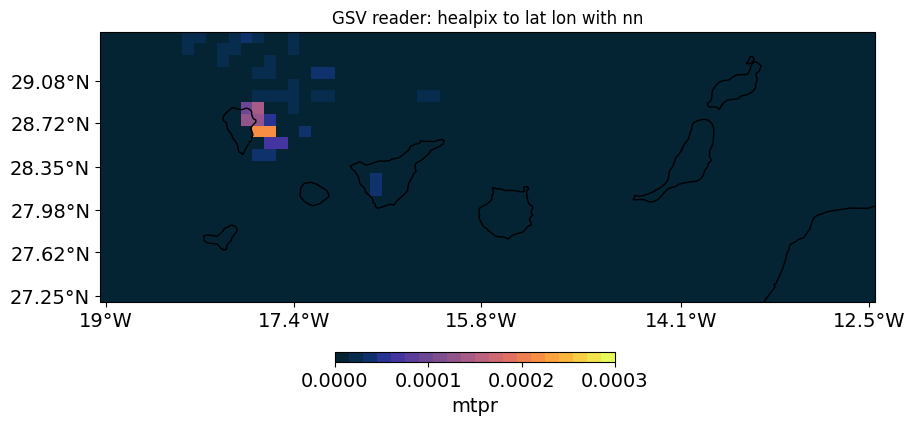

In [120]:
# GSV uses nn CDO regrid method 

request = {
    "class": "d1",
    "dataset": "climate-dt",
    "experiment": "hist",
    "activity": "CMIP6",
    "model": "IFS-FESOM",
    "realization": 1,
    "generation": 1,
    "type": "fc",
    "stream": "clte",
    "resolution": "high",
    "expver": "huhu",
    "param": "tp",
    "levtype": "sfc",
    "time": "0000",
    "date": ["19900101"],
    "grid": "0.1/0.1",
    "time": ["0000", "0100","0200", "0300","0400", "0500","0600", "0700","0800", "0900","1000", "1100","1200",
            "1300", "1400","1500", "1600","1700", "1800","1900", "2000","2100", "2200","2300"],
    "area":f"{latitude[1]}/{longitude[0]}/{latitude[0]}/{longitude[1]}"

}

gsv = GSVRetriever()
ds = gsv.request_data(request)
ds = ds['tp']
# converting to mtpr (m to kg/m2 s)
ds_mtpr = ds*1000/(60*60)

plot_islands(ds_mtpr.sum(axis = 0), "lat_lon", cbar_max, "GSV reader: healpix to lat lon with nn")

absolute RMS error: 9.703e-06


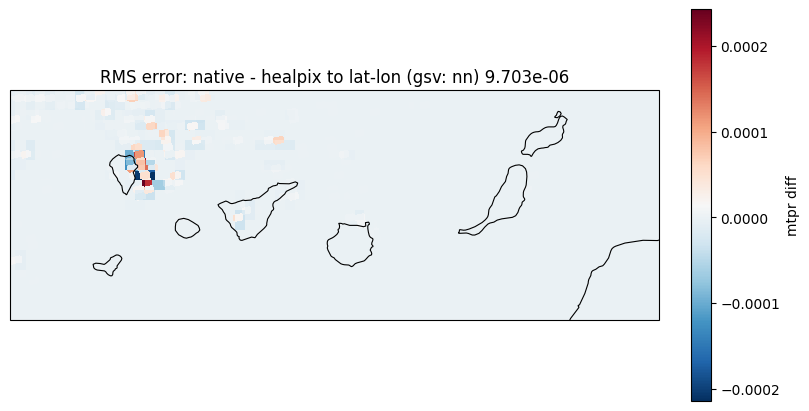

In [125]:

# this one is the same as nn from aqua cdo - running to check
# small differences in error but above plot looks the same. Probably due to conversion of tp to mtpr and assumed water density

fig, ax, ds_error = plot_map_diff(
    data_nat.sum(axis = 0),
    ds_mtpr.sum(axis = 0),
    cmap="RdBu_r",
    interpolation="none",
    colorbar_label="mtpr diff",
    title="RMS error: native - healpix to lat-lon (gsv: nn)",
)

# summary of errors

In [124]:

print('origin: native, regrid: lat-lon, method: cdo-ycon, RMS error:', nat_ll_error)
print('origin: native, regrid: lat-lon, method: cdo-nn, RMS error:', nat_ll_nn_error)
print('origin: native, regrid: lat-lon, method: cdo-dis, RMS error:', nat_ll_dis_error)
print('origin: native, regrid: lat-lon, method: cdo-laf, RMS error:', nat_ll_laf_error)

print('origin: healpix, regrid: lat-lon, method: cdo-ycon, RMS error:', hp_ll_error)
print('origin: healpix, regrid: lat-lon, method: cdo-nn, RMS error:', hp_ll_nn_error)
print('origin: healpix, regrid: lat-lon, method: cdo-dis, RMS error:', hp_ll_dis_error)
print('origin: healpix, regrid: lat-lon, method: cdo-laf, RMS error:', hp_ll_laf_error)

print('origin: healpix, regrid: lat-lon, method: own-nn, RMS error:', hp_ll_own_nn_error)
print('origin: healpix, regrid: lat-lon, method: own-nn-ss, RMS error:', hp_ll_own_nn_ss_error)

print('origin: healpix, regrid: none, method: none, RMS error:', hp_error)


origin: native, regrid: lat-lon, method: cdo-ycon, RMS error: 7.7716e-06
origin: native, regrid: lat-lon, method: cdo-nn, RMS error: 1.02201e-05
origin: native, regrid: lat-lon, method: cdo-dis, RMS error: 7.874e-06
origin: native, regrid: lat-lon, method: cdo-laf, RMS error: 7.7716e-06
origin: healpix, regrid: lat-lon, method: cdo-ycon, RMS error: 8.7869e-06
origin: healpix, regrid: lat-lon, method: cdo-nn, RMS error: 9.703e-06
origin: healpix, regrid: lat-lon, method: cdo-dis, RMS error: 9.1199e-06
origin: healpix, regrid: lat-lon, method: cdo-laf, RMS error: 8.7869e-06
origin: healpix, regrid: lat-lon, method: own-nn, RMS error: 9.652e-06
origin: healpix, regrid: lat-lon, method: own-nn-ss, RMS error: 8.5259e-06
origin: healpix, regrid: none, method: none, RMS error: 8.5041e-06


## nextGEMS data

In [28]:
# cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

# #print(list(cat.IFS)) #['IFS_9-FESOM_5-production']
# print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) 

# exp_id = 'IFS_4.4-FESOM_5-cycle3'
# stream = "2D_1h_native" # e.g. '2D_monthly_0.25deg', '3D_monthly_0.25deg'
# dataset = cat.IFS[exp_id][stream].to_dask() # (chunks={}).to_dask().drop_duplicates('time', keep='last')


In [29]:
# dataset.lon.values

In [30]:
# data_tp = dataset['tp']
# data_tp.lat.values

# data_tp['lon_adjusted'] = xr.where(data_tp.lon > 180, data_tp.lon - 360, data_tp.lon)
# data_tp['lon'] = data_tp['lon_adjusted']
# data_tp = data_tp.reset_coords(names='lon_adjusted', drop=True)

In [31]:
# data_tp

In [32]:
# data_tp = data_tp[0:10, :]
# #np.triangulation

In [33]:
# # coordinates of Canary islands whole domain 
# latitude = [27.2, 29.5]
# longitude = [-19, -12.5]

# # coordinates for Tenerife north side
# latitude_ten = [28.3, 28.6]
# longitude_ten = [-16.9, -16.1]

# indexer = ((data_tp.lat>=latitude[0]) & (data_tp.lat<=latitude[1]) & (data_tp.lon>=longitude[0]) & (data_tp.lon<=longitude[1])).compute()
# data_tp_ci = data_tp.where(indexer, drop=True)

# indexer = ((data_tp.lat>=latitude_ten[0]) & (data_tp.lat<=latitude_ten[1]) & (data_tp.lon>=longitude_ten[0]) & (data_tp.lon<=longitude_ten[1])).compute()
# data_tp_ten_n = data_tp.where(indexer, drop=True)